# **Read DATA**

*****************************
Please make sure you use the same gpu shown below : 
*****************************

In [1]:
!nvidia-smi

Wed Dec  2 22:21:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

*********************
Please upload your kaggle json : you can find it in your profile 
*********************

In [2]:
from google.colab import files
!pip install -q kaggle
files.upload() #kaggle.json file downloaded from api
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [3]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ttahara/pytorch-pfn-extras
!unzip pytorch-pfn-extras.zip -d  pytorch-pfn-extras


  0% 0.00/129k [00:00<?, ?B/s]
100% 129k/129k [00:00<00:00, 40.1MB/s]
Archive:  pytorch-pfn-extras.zip
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/PKG-INFO  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/README.md  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras.egg-info/PKG-INFO  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras.egg-info/SOURCES.txt  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras.egg-info/dependency_links.txt  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras.egg-info/requires.txt  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras.egg-info/top_level.txt  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras/__init__.py  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras/_version.py  
  inflating: pytorch-pfn-extras/pytorch-pfn-extras-0.3.1/pytorch_pfn_extras/

In [4]:
%%bash
pip install /content/pytorch-pfn-extras/pytorch-pfn-extras-0.3.1

Processing ./pytorch-pfn-extras/pytorch-pfn-extras-0.3.1
  Created wheel for pytorch-pfn-extras: filename=pytorch_pfn_extras-0.3.1-cp36-none-any.whl size=99756 sha256=8f1ab64eb40bb3f7b3201a03b0db29ffd8779b5bd9d1553af1e1ce33d4b0fd33
  Stored in directory: /root/.cache/pip/wheels/ad/71/c5/c3160f7184b3a8562729fde266c86eea7594161ddec85ad01a
Successfully built pytorch-pfn-extras


In [5]:
import os
import cv2
import sys
import time
import math

import random
import librosa
import warnings
#import torchaudio
#import torchvision
import numpy as np
import pandas as pd
import typing as tp
import IPython.display as ipd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU


pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
path="/content/drive/MyDrive/Zindi/Competitions/GIZ"

In [8]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #False

In [9]:
SEED_VAL = 1213
seed_everything(SEED_VAL)

In [10]:
!cp "/content/drive/My Drive/Zindi/Competitions/GIZ/Train.csv" .
!cp "/content/drive/My Drive/Zindi/Competitions/GIZ/SampleSubmission.csv" .
!cp "/content/drive/My Drive/Zindi/Competitions/GIZ/audio_files.zip" .
!cp "/content/drive/My Drive/Zindi/Competitions/GIZ/AdditionalUtterances.zip" .
!cp "/content/drive/My Drive/Zindi/Competitions/GIZ/nlp_keywords_29Oct2020.zip" .

In [11]:
!unzip AdditionalUtterances.zip 
!unzip audio_files.zip
!unzip nlp_keywords_29Oct2020.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: latest_keywords/ebisaanyi/3d43af6faf2244c288154dc4ff6a734f_34df793d29d44266adf25664e8c6dc03.wav  
  inflating: latest_keywords/omucungwa/2497942026ef4d7e97d47fc2738d7c27_45c35e9401a0409899981a0b96f1753a.wav  
  inflating: latest_keywords/ppaapaali/79aac18aacc74cc092d00778f7f323da_e932f971e74b4fd99c69a88b98464010.wav  
  inflating: latest_keywords/ekirwadde/3d43af6faf2244c288154dc4ff6a734f_e9125deee38442b5a183fb5ea8df15d7.wav  
  inflating: latest_keywords/omulimi/1b5a69c4b88b41eb9577a656e11bb7dd_78896821953949ab8c97f5a796aeb6d8.wav  
  inflating: latest_keywords/emboga/2497942026ef4d7e97d47fc2738d7c27_cda86edbc31044b995d13453f3d302f6.wav  
  inflating: latest_keywords/ekyeya/5aa4893526794a73a3ed0a7ebba2a7bf_6f0a37308160411da68c2ab09cd303f6.wav  
  inflating: latest_keywords/micungwa/0a8fccdb95b749dca0404bf433872764_65fb16ebbb724378b23d281d8673d0d2.wav  
  inflating: latest_keywords/ebikongoliro/0

In [12]:
!rm AdditionalUtterances.zip
!rm audio_files.zip
!rm nlp_keywords_29Oct2020.zip

In [13]:
train = pd.read_csv("Train.csv")

In [14]:
def create_new_train():  
  import glob
  dirs = glob.glob('latest_keywords/*')
  new_atterances = pd.DataFrame()
  labels = []
  fn = []
  for dir in dirs:
    wav_paths = glob.glob(dir+'/*')
    fn.extend(wav_paths)
    labels.extend(len(wav_paths) * [dir.split('/')[-1]])
  new_atterances['fn'] = fn
  new_atterances['label'] = labels
  new_atterances = new_atterances.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)
  train = pd.read_csv('Train.csv')
  train = pd.concat([train,new_atterances])
  train = train.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)
  train.to_csv('new_train.csv',index=False)
  print(train.head())
create_new_train()
def create_new_train_1():  
  import glob
  dirs = glob.glob('nlp_keywords/*')
  new_atterances = pd.DataFrame()
  labels = []
  fn = []
  for dir in dirs:
    wav_paths = glob.glob(dir+'/*')
    fn.extend(wav_paths)
    labels.extend(len(wav_paths) * [dir.split('/')[-1]])
  new_atterances['fn'] = fn
  new_atterances['label'] = labels
  new_atterances = new_atterances.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)
  train = pd.read_csv('new_train.csv')
  train = pd.concat([train,new_atterances])
  train = train.sample(frac=1,random_state=SEED_VAL).reset_index(drop=True)
  train.to_csv('final_train.csv',index=False)
  print(train.head())

create_new_train_1()

                                                  fn      label
0  latest_keywords/abalimi/1b5a69c4b88b41eb9577a6...    abalimi
1                            audio_files/6QRKXIC.wav   ebikajjo
2                            audio_files/K4V0N40.wav   ebisooli
3                            audio_files/V9CM2BC.wav  obusaanyi
4  latest_keywords/kisaanyi/d45cd9903b3044d494866...   kisaanyi
                                                  fn      label
0                            audio_files/T76GMLD.wav     bulimi
1                            audio_files/H536AW2.wav        npk
2  nlp_keywords/ejjobyo/6fbfcce2cf21419e97290f9e1...    ejjobyo
3  latest_keywords/obulwadde/3d43af6faf2244c28815...  obulwadde
4  nlp_keywords/ppaapaali/d027264654b94950aeb204f...  ppaapaali


In [15]:
train = pd.read_csv("final_train.csv")

In [16]:
train.shape

(4709, 2)

In [17]:
sub = pd.read_csv("SampleSubmission.csv")

# **Parameters :**

In [18]:
CLASSES = sub.columns[1:]
NUM_CLASSES = len(CLASSES)
NUM_WORKERS = 4

In [19]:
CLASSES_CODE = {i:index for index,i in enumerate(CLASSES) }
INV_CLASSES_CODE = {v: k for k, v in CLASSES_CODE.items()}


In [20]:
melspectrogram_parameters = {
        "sampling_rate": 16000,
        "duration" : 3.5,
        "n_mels": 32,
        "fmin": 20,## changed from 50  
        "fmax": 8000,
        "hop_length" : 100,  # to make width= 128
        "n_fft" : 512
    }

In [21]:
!mkdir training_output

In [22]:
settings_str = """
globals:

  seed: 1213
  device: cuda
  num_epochs: 15
  output_dir: /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/
  use_fold: 0
  target_sr: 41000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 64

    
split:
  name: StratifiedKFold
  params:
    n_splits: 10
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 8
    shuffle: True
    num_workers: 2
    pin_memory: True
    drop_last: True
  val:
    batch_size: 32
    shuffle: False
    num_workers: 2
    pin_memory: True
    drop_last: False
  test:
    batch_size: 32
    shuffle: False
    num_workers: 2
    pin_memory: True
    drop_last: False

model:
  name: resnest269
  params:
    pretrained: True
    n_classes: 193

loss:
  name: CrossEntropyLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.00008

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 5
"""

In [23]:
import yaml
settings = yaml.safe_load(settings_str)

# **Save Melsepcs to Disque**

In [24]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [25]:
def melspectogram_dB(file_path, cst=5, top_db=80.):
  row_sound, sr = librosa.load(file_path,sr=melspectrogram_parameters["sampling_rate"])
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, 
                                    sr=melspectrogram_parameters["sampling_rate"],
                                    n_mels=melspectrogram_parameters["n_mels"],
                                    hop_length=melspectrogram_parameters["hop_length"],
                                    n_fft=melspectrogram_parameters["n_fft"],
                                    fmin=melspectrogram_parameters["fmin"],
                                    fmax=melspectrogram_parameters["fmax"])
  spec_db = librosa.power_to_db(spec)
  spec_db = spec_db.astype(np.float32)

  return spec_db
  
  
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)



def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

In [26]:
# Add file names
from tqdm import tqdm
def add_file_name(train=train,submission=sub) : 
  train['spec_name'] = 'Imgs/Train/'+train['fn'].apply(lambda x : x.split('/')[-1].split('.')[0])+'.png'

  submission['spec_name'] = 'Imgs/Test/'+submission['fn'].apply(lambda x : x.split('/')[-1].split('.')[0])+'.png'
  return train , submission

In [27]:
train , submission = add_file_name(train=train,submission=sub)

In [28]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('Imgs/Train/', exist_ok=True)
os.makedirs('Imgs/Test/', exist_ok=True)

In [29]:
train.loc[1,'spec_name']

'Imgs/Train/H536AW2.png'

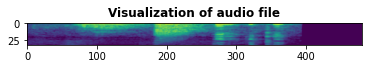

In [30]:
spec = melspectogram_dB(train.loc[1,'fn'], 3)

plt.figure(figsize=(6,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(spec)

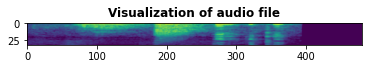

In [31]:
spec = melspectogram_dB(train.loc[1,'fn'], 3)

plt.figure(figsize=(6,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(spec)
img = spec_to_image(spec)


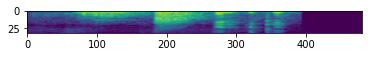

In [32]:
plt.imshow(img)

In [33]:
#Training specs
"""
for row in tqdm(train.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[2] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)
"""

"\nfor row in tqdm(train.values):\n  sound_path = row[0] #this corresponds to 'file_name'\n  spec_name = row[2] #this corresponds to 'spec_name'\n\n  spec = melspectogram_dB(sound_path, 3)\n  spec = spec_to_image(spec)\n  save_spec_image(spec, spec_name)\n"

In [34]:
#Training specs
for row in tqdm(submission.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[-1] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

100%|██████████| 1017/1017 [03:29<00:00,  4.86it/s]


# **DataSet Building :**

In [35]:
import albumentations
from albumentations.core.transforms_interface import DualTransform, BasicTransform


In [36]:
class AudioTransform(BasicTransform):
    """Transform for Audio task"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params


In [37]:
class MelSpectrogram(AudioTransform):
    """Shifting time axis"""
    def __init__(self, parameters, always_apply=False, p=0.5):
        super(MelSpectrogram, self).__init__(always_apply, p)

        self.parameters = parameters
    
    def apply(self, data, **params):
        sound, sr = data

        melspec = librosa.feature.melspectrogram(sound, sr=sr, **self.parameters)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.astype(np.float32)

        return melspec, sr

In [38]:
audio_augmentation_train = albumentations.Compose([
     MelSpectrogram(parameters=melspectrogram_parameters,always_apply=True),
])
audio_augmentation_valid = albumentations.Compose([
     MelSpectrogram(parameters=melspectrogram_parameters,always_apply=True),
])

In [39]:
import matplotlib.pyplot as plt
import imageio
import cv2

class SpectrogramDataset(data.Dataset):
    def __init__(
        self,
        file_list: tp.List[tp.List[str]], img_size=224,
        waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={},
        train_bool = True
    ):
        self.file_list = file_list  # list of list: [file_path, Class_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.train_bool = train_bool

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        #wav_path, word_code = self.file_list[idx]
        if self.train_bool:
          melspec_path, word_code = self.file_list[idx]
        else: 
          melspec_path = self.file_list[idx]

        image = cv2.imread(melspec_path,cv2.IMREAD_GRAYSCALE)                    
        height, width = image.shape

        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))


        labels = 0

        if self.train_bool:
          labels = CLASSES_CODE[word_code[0]]
          return image, labels
        else:
          return image

In [40]:
def get_loaders_for_training(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    train_file_list: tp.List[str], val_file_list: tp.List[str]
):

    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list,spectrogram_transforms=audio_augmentation_train, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list,spectrogram_transforms=audio_augmentation_valid, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, val_loader

# **Modeling :**

In [41]:
def get_model(args: tp.Dict):
  
    # get list of models
    torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
    # load pretrained models, using ResNeSt-50 as an example
    model = torch.hub.load('zhanghang1989/ResNeSt', args["name"], pretrained = args["params"]["pretrained"])
    
    weight_new = model.conv1[0].weight
    conv2_new =  Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) 
    
    model.conv1[0] = conv2_new
    model.conv1[0].weight = torch.nn.Parameter(model.conv1[0].weight.sum(dim=1, keepdim=True))
       

    del model.fc
   
    # # use the same head as the baseline notebook.
    
    model.fc = nn.Sequential(
        nn.Linear(2048, args["params"]["n_classes"]))
    
    
    return model

In [42]:
def train_loop(
    manager, args, model, device,
    train_loader, optimizer, scheduler, loss_func
):
    """Run minibatch training loop"""
    while not manager.stop_trigger:
        model.train()
        progress_bar = tqdm_notebook(train_loader)
        for batch_idx, (data, target) in enumerate(progress_bar):
            with manager.run_iteration():
               
                data = data.type(torch.FloatTensor)

                data, target = data.to(device, dtype=torch.float), target.to(device,dtype=torch.long)
                
                optimizer.zero_grad()

                output = model(data.unsqueeze(dim=1))
                loss = loss_func(output, target)
                progress_bar.set_description(f'train/loss: {loss.item():.6f}')
                ppe.reporting.report({'train/loss': loss.item()})
                loss.backward()
                optimizer.step()
            if scheduler : 
              scheduler.step()

def eval_for_batch(
    args, model, device,
    data, target, loss_func, eval_func_dict={}
):
    """
    Run evaliation for valid
    
    This function is applied to each batch of val loader.
    """
    model.eval()
    data = data.type(torch.FloatTensor)
    data, target = data.to(device, dtype=torch.float), target.to(device,dtype=torch.long)
    output = model(data.unsqueeze(dim=1))
    # Final result will be average of averages of the same size
    val_loss = loss_func(output, target).item()
    ppe.reporting.report({'val/loss': val_loss})
    
    for eval_name, eval_func in eval_func_dict.items():
        eval_value = eval_func(output, target).item()
        ppe.reporting.report({"val/{}".format(eval_name): eval_value})

In [43]:
def set_extensions(
    manager, args, model, device, test_loader, optimizer,
    loss_func,fold, eval_func_dict={},
    
):
    """set extensions for PPE"""
    use_fold = fold     
    my_extensions = [
        # # observe, report
        ppe_extensions.observe_lr(optimizer=optimizer),
        # ppe_extensions.ParameterStatistics(model, prefix='model'),
        # ppe_extensions.VariableStatisticsPlot(model),
        ppe_extensions.LogReport(),
        ppe_extensions.PlotReport(['train/loss', 'val/loss'], 'epoch', filename='loss.png'),
        ppe_extensions.PlotReport(['lr',], 'epoch', filename='lr.png'),
        ppe_extensions.PrintReport([
            'epoch', 'iteration', 'lr', 'train/loss', 'val/loss', "elapsed_time"]),
#         ppe_extensions.ProgressBar(update_interval=100),

        # # evaluation
        (
            ppe_extensions.Evaluator(
                test_loader, model,
                eval_func=lambda data, target:
                    eval_for_batch(args, model, device, data, target, loss_func, eval_func_dict),
                progress_bar=True),
            (1, "epoch"),
        ),
        # # save model snapshot.
        (
            ppe_extensions.snapshot(
                target=model, filename=f"best_fold_{use_fold}.pth"),
            ppe.training.triggers.MinValueTrigger(key="val/loss", trigger=(1, 'epoch'))
        ),
        
        
    ]
           
    # # set extensions to manager
    for ext in my_extensions:
        if isinstance(ext, tuple):
            manager.extend(ext[0], trigger=ext[1])
        else:
            manager.extend(ext)
        
    return manager

# **Get WAVs**

In [44]:
train.head()

,fn,label,spec_name
0,audio_files/T76GMLD.wav,bulimi,Imgs/Train/T76GMLD.png
1,audio_files/H536AW2.wav,npk,Imgs/Train/H536AW2.png
2,nlp_keywords/ejjobyo/6fbfcce2cf21419e97290f9e1...,ejjobyo,Imgs/Train/6fbfcce2cf21419e97290f9e12934f65_9e...
3,latest_keywords/obulwadde/3d43af6faf2244c28815...,obulwadde,Imgs/Train/3d43af6faf2244c288154dc4ff6a734f_e0...
4,nlp_keywords/ppaapaali/d027264654b94950aeb204f...,ppaapaali,Imgs/Train/d027264654b94950aeb204f64d05d8d7_35...


In [45]:
from sklearn.model_selection import StratifiedKFold


In [46]:
skf = StratifiedKFold(**settings["split"]["params"])

train["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train, train["label"])):
    train.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train, index="label", columns="fold", aggfunc=len)
print(fold_proportion.shape)

(193, 20)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [47]:
use_fold = settings["globals"]["use_fold"]
train_file_list = train.query("fold != @use_fold")[["spec_name", "label"]].values.tolist()
val_file_list = train.query("fold == @use_fold")[["spec_name", "label"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 0] train: 4238, val: 471


In [48]:
#transform lists to list of lists
for i in range(len(train_file_list)):
    train_file_list[i][1] = [train_file_list[i][1]]
for i in range(len(val_file_list)):
    val_file_list[i][1] = [val_file_list[i][1]]

In [49]:
def get_loader_for_testing(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    test_file_list: tp.List[str]
):
    
    
    # # make dataset
    test_dataset = SpectrogramDataset(test_file_list, **args_dataset,train_bool = False)
    # # make dataloader
    test_loader = data.DataLoader(test_dataset, **args_loader["test"])
    
    return test_loader

In [50]:

def prediction(test_loader, 
                        model, 
                        ):

    model.eval()
    final_outputs = []
    with torch.no_grad():
      tk0 = tqdm(test_loader, total=len(test_loader))
      for batch_index,data in enumerate(tk0):
        #send them to device 
        data = data.to(device,dtype=torch.float)
        outputs  = model(data.unsqueeze(dim=1))
        final_outputs.extend(torch.nn.functional.softmax(outputs).cpu().detach().numpy())

    return final_outputs





# **PREDICTION :**

In [51]:
NUM_FOLDS = settings["split"]["params"]["n_splits"]

***********************************************
**Ps** : replace the paths below to your resnest269 folder in the drive that contains trained models from part 1 and part 2 of training 
*********************************************** 

In [52]:
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_0.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_1.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_2.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_3.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_4.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_5.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_6.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_7.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_8.pth .
!cp /content/drive/MyDrive/Zindi/Competitions/GIZ/resnest269/best_fold_9.pth .



In [54]:
predictions = []
device = torch.device(settings["globals"]["device"])
for i in range(NUM_FOLDS): 
  use_fold = i
  test_file_list = submission["spec_name"].values.tolist()
  #transform lists to list of lists


  test_loader = get_loader_for_testing(
  settings["dataset"]["params"], settings["loader"], test_file_list)

  model = get_model(settings["model"])
  state_dict = torch.load(f"best_fold_{use_fold}.pth")

  model.load_state_dict(state_dict)  
  model = model.to(device)  


  prediction_fold = prediction(test_loader,model)

  predictions.append(prediction_fold)

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
100%|██████████| 32/32 [00:21<00:00,  1.49it/s]
Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 32/32 [00:21<00:00,  1.49it/s]
Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 32/32 [00:22<00:00,  1.45it/s]
Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip"

# **SUBSMISSION**

In [55]:
#preds = np.mean(predictions,0)

In [56]:
from scipy.stats import gmean

gmean_preds =  gmean(predictions,0)

In [61]:
submission.loc[:,1:-1]= gmean_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.


In [62]:
final_sub = submission.drop("spec_name",axis=1)

In [63]:
final_sub.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,ensukusa,maize stalk borer,amakoola,muceere,insect,pumpkin,spray,namuginga,tomatoes,akatungulu,ground nuts,orange,nursery bed,npk,mangoes,ebitooke,maize,endwadde,lumonde,ensiringanyi,pawpaw,ebijjanjalo,sukumawiki,caterpillars,matooke seedlings,okusaasaana,omuceere,ebikajjo,mulimi,sikungula,watermelon,ennima,akammwanyi,amakungula,ebyobulimi,okugimusa,sow,Pump,ekigimusa,ekirime,okusiga,nfukirira,faamu,okulimibwa,pampu,vegetables,lusuku,ennyaanya,ekisaanyi,bibala,ekikajjo,ennimiro,okukungula,akatunda,eppapaali,endagala,ekijanjaalo,abalimi,plant,Spinach,ndwadde,caterpillar,miceere,farmer,irrigate,nnakati,omusiri,weeding,okusaasaanya,amalagala,ekikoola,ebisooli,munyeera,ekirwadde,enkota,banana,fruit picking,ebibala,dig,doodo,omulimisa,eggobe,seed,crop,okunnoga,obutunda,fruit,endokwa,ebikolo,omucungwa,okufukirira,obulwadde,ebijanjaalo,matooke,pepper,agriculture,afukirira,nnyaanya,medicine,nambaale,cassava,sugarcane,ekimera,kikajjo,obusaanyi,ekibala,ebigimusa,kukungula,nnimiro,ebikongoliro,irish potatoes,ensuku,emicungwa,ekikolo,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,1.730864e-03,2.833691e-06,1.020704e-04,2.835209e-05,9.008569e-06,1.121298e-05,8.030047e-04,3.983966e-05,8.042968e-05,2.199954e-06,2.579570e-05,1.846475e-06,7.189325e-07,1.290607e-05,2.238721e-05,2.325626e-04,1.214619e-04,4.940503e-06,5.052903e-05,1.179248e-04,1.975660e-06,9.832803e-03,1.250650e-04,2.357697e-05,1.465250e-04,5.460863e-06,6.760526e-05,2.054893e-03,1.400591e-05,3.824877e-02,1.919245e-04,2.335991e-03,4.477937e-06,7.442911e-06,1.090494e-06,1.142945e-04,1.797614e-05,2.050675e-06,2.093169e-03,3.834923e-04,3.422675e-04,5.781531e-05,1.555313e-05,1.751789e-03,6.420733e-04,2.354333e-03,1.448010e-04,1.491921e-03,9.485893e-05,6.860702e-04,3.228516e-04,5.448324e-05,1.291810e-04,2.147357e-03,6.372324e-07,2.845705e-05,1.985782e-05,5.836080e-07,3.684956e-05,6.802837e-03,3.317003e-07,1.342044e-04,2.472300e-03,1.065594e-02,1.343329e-03,3.789486e-06,4.129183e-05,1.378496e-05,4.636097e-05,4.636580e-03,7.306223e-06,9.736188e-05,4.337677e-05,1.554161e-06,1.139666e-04,4.561069e-06,8.096667e-06,5.383612e-05,6.016745e-07,2.760423e-05,1.356390e-04,1.936798e-06,9.086487e-05,1.001727e-05,2.556261e-03,7.039710e-05,1.568072e-06,9.603153e-06,1.572756e-06,7.160328e-05,6.248297e-07,2.930932e-05,1.845262e-04,2.062138e-04,2.689865e-05,4.815586e-04,1.346389e-05,1.134201e-04,4.847344e-04,2.556822e-05,5.524239e-03,1.492824e-05,1.887778e-04,4.099780e-06,1.774828e-04,7.291629e-07,7.924762e-07,5.526230e-04,1.053163e-04,2.267772e-04,2.097745e-07,1.885286e-05,2.035735e-05,1.306470e-04,4.278244e-04,6.215397e-05,5.072002e-07,3.034448e-05,2.926384e-06,4.216388e-06,1.526407e-04,5.315801e-06,7.799193e-04,5.880782e-05,6.448832e-06,5.878898e-05,2.037939e-05,4.888466e-06,2.667699e-06,6.798543e-05,1.687010e-04,3.334524e-05,1.216732e-05,1.998210e-03,2.985454e-04,3.806668e-05,1.824687e-07,2.754293e-04,1.427589e-06,6.184981e-03,6.069585e-04,4.457256e-06,2.662160e-05,8.086966e-06,5.036209e-07,3.290330e-05,1.397784e-05,1.454392e-06,2.245334e-05,2.310973e-03,4.400557e-06,5.380678e-06,9.202389e-06,2.448754e-06,8.125368e-07,1.466452e-04,3.083497e-03,5.049656e-05,6.525176e-05,1.308364e-05,8.501912e-04,7.095015e-06,1.631334e-05,4.511915e-07,0.000004,1.681058e-06,5.461751e-07,6.457756e-06,1.626184e-04,3.038033e-05,1.752

In [64]:
final_sub.to_csv("resnest269_gmean.csv",index=False)